<a href="https://colab.research.google.com/github/mehdi-or/VT2PFC/blob/main/TRACE_with_Concatenation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##setting random seed for reproducibility

In [ ]:
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)  # Python random module
    np.random.seed(seed_value)  # Numpy module
    torch.manual_seed(seed_value)  # PyTorch random number generator for CPU

    # If you are using CUDA
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.

    # Additional configurations to enhance reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

##Architecture of the model

In [ ]:
class DATRACE(nn.Module):
    def __init__(self, input_size_VT, input_size_PF, hidden_size, bottleneck_size, num_classes):
        super(DATRACE, self).__init__()
        # Encoder
        self.VT_in = nn.Linear(input_size_VT, hidden_size)
        self.PF_in = nn.Linear(input_size_PF, hidden_size)
        self.concat = nn.Linear(2*hidden_size, hidden_size)
        self.fc_BN = nn.Linear(hidden_size, bottleneck_size)

        # Decoder
        self.fc = nn.Linear(bottleneck_size, hidden_size)
        self.PF_out = nn.Linear(hidden_size, input_size_PF)
        self.VT_out = nn.Linear(hidden_size, input_size_VT)

        # Classifier connected to the bottleneck
        self.classifier = nn.Linear(bottleneck_size, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.2)

    def forward (self, x1, x2):
        # Encoder
        encoded_VT = torch.tanh(self.VT_in(x1))
        encoded_VT = self.dropout(encoded_VT)

        encoded_PF = torch.tanh(self.PF_in(x2))
        encoded_PF = self.dropout(encoded_PF)

        concatenated = torch.cat((encoded_VT, encoded_PF), dim=1)
        encoded_concat = torch.tanh(self.concat(concatenated))
        BN = torch.tanh(self.fc_BN(encoded_concat))

        # Decoder
        x3 = torch.tanh(self.fc(BN))
        decoded_PF = self.PF_out(x3)

        x4 = torch.tanh(self.fc(BN))
        decoded_VT = self.VT_out(x4)

        # Classifier
        logits = self.classifier(BN) # logsoft is automatically applied behinde the scence

        return decoded_PF, decoded_VT, logits


# Example model instantiation
input_size_VT = 1500 # e.g., for MNIST
input_size_PF = 1000
hidden_size = 128
bottleneck_size = 32
num_classes = 10 # e.g., for MNIST classification

model = DATRACE(input_size_VT=input_size_VT, input_size_PF=input_size_PF, hidden_size=hidden_size,
                                  bottleneck_size=bottleneck_size, num_classes=num_classes)
#testing wheather the model work as it  should
x1=torch.rand(2,input_size_VT)
x2=torch.rand(2,input_size_PF)
print(model.forward(x1,x2))


##Importing the actual VTC and PFC data and feeding them to dataloader

In [57]:
def load_data_VTC(subject):
    with h5py.File(r'/content/gdrive/MyDrive/Colab Notebooks/CNC data/hrfAll_VT_PETERS.hdf5', 'r') as hdf:
        data0 = hdf.get('items/'+str(subject)+'/rcargs/items/0')
        data_vtc = np.array(data0)
        data_vtc = np.delete(data_vtc,np.where(~data_vtc.any(axis=0))[0],axis=1)
    return(data_vtc)

def load_data_PFC(subject):
    with h5py.File(r'/content/gdrive/MyDrive/Colab Notebooks/CNC data/hrfAll_DLPFC_PETERS.hdf5', 'r') as hdf:
        data0_pfc = hdf.get('items/'+str(subject)+'/rcargs/items/0')
        data_pfc = np.array(data0_pfc)
        data_pfc = np.delete(data_pfc,np.where(~data_pfc.any(axis=0))[0],axis=1)
    return(data_pfc)

def preprocessign (data, labels2categ, shuffle_index):
  data_train, data_test, y_categ_train, y_categ_test, map_train_index, map_test_index = train_test_split(data, labels2categ, shuffle_index, random_state=42)
  #scaler = StandardScaler()
  scaler = MinMaxScaler(feature_range=(-1,1))
  X_train = scaler.fit_transform(data_train)
  X_test = scaler.transform(data_test)
  return X_train, X_test, y_categ_train, y_categ_test, map_train_index, map_test_index

#setting the labels for pytorch is differen from keras
# the way it works is that we need to assign a number to each categorical class
unique_labels = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CNC data/unique_aranged.csv', header=None).values[:,1]
labels = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CNC data/label.csv')['y'].values
label_to_index = {label: idx for idx, label in enumerate(unique_labels)} #mapping form label to its numeric value
index_to_label = {idx: label for label, idx in label_to_index.items()} #mapping from numeric label to the name of the label

#turning label file into its numeric values
numeric_labes = []
for label in labels:
  numeric_labes.append(label_to_index[label])

numeric_labes = np.array(numeric_labes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#converting all the numpy array inot pytorch tensor

VTC = load_data_VTC(37)
PFC = load_data_PFC(37)
shuffle_index = np.arange(0,3600)
VTC_train, VTC_test, y_train, y_test, map_train_index, map_test_index = preprocessign(VTC, numeric_labes, shuffle_index)
PFC_train, PFC_test, _, _, _, _ = preprocessign(PFC, numeric_labes, shuffle_index)

VTC_tensor_train = torch.tensor(VTC_train, dtype=torch.float32).to(device)
VTC_tensor_test = torch.tensor(VTC_test, dtype=torch.float32).to(device)

PFC_tensor_train = torch.tensor(PFC_train, dtype=torch.float32).to(device)
PFC_tensor_test = torch.tensor(PFC_test, dtype=torch.float32).to(device)

y_tensor_train = torch.tensor(y_train)
y_tensor_test =torch.tensor(y_test)

train_dataset = TensorDataset(VTC_tensor_train, PFC_tensor_train, y_tensor_train)
test_dataset = TensorDataset(VTC_tensor_test, PFC_tensor_test, y_tensor_test)



##Training the network

Epoch 15, Train Loss: 1.0889, Validation Loss: 1.0468
Epoch 30, Train Loss: 0.6342, Validation Loss: 0.6074
Epoch 45, Train Loss: 0.4357, Validation Loss: 0.4121
Epoch 60, Train Loss: 0.3233, Validation Loss: 0.3047
Epoch 75, Train Loss: 0.2578, Validation Loss: 0.2420
Epoch 90, Train Loss: 0.2154, Validation Loss: 0.2029
Epoch 105, Train Loss: 0.1880, Validation Loss: 0.1779
Epoch 120, Train Loss: 0.1695, Validation Loss: 0.1609
Epoch 135, Train Loss: 0.1553, Validation Loss: 0.1489
Epoch 150, Train Loss: 0.1455, Validation Loss: 0.1400


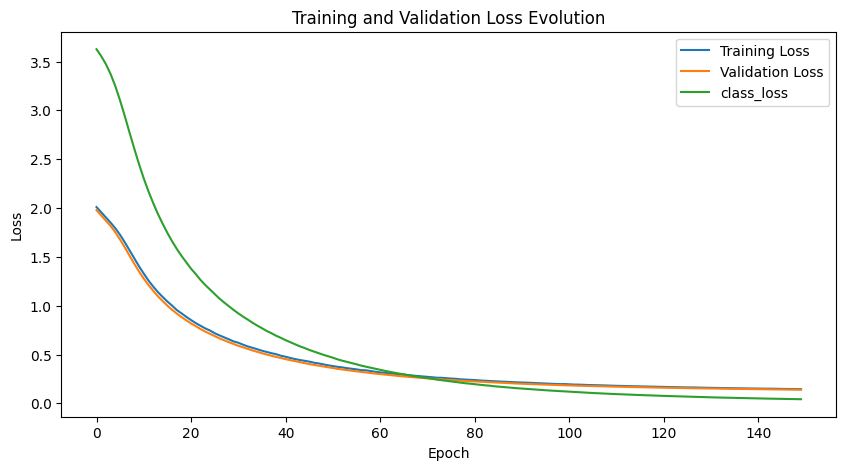

In [58]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
# 2. Define the model, optimizer, and loss functions
input_size_VT = VTC_train.shape[1]
input_size_PF = PFC_train.shape[1]
hidden_size = 500
bottleneck_size = 50
num_classes = len(unique_labels)
model = DATRACE(input_size_VT, input_size_PF, hidden_size, bottleneck_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
reconstruction_loss_fn = nn.MSELoss()
classification_loss_fn = nn.CrossEntropyLoss()

# Track loss evolution
train_loss_history = []
val_loss_history = []
class_loss_history = []

alpha = 0.5 # Classifier weigth of the network

# 3. Training loop
num_epochs = 150
for epoch in range(num_epochs):
    set_seed(42 + epoch)
    model.train()
    train_loss = 0
    for VTC, PFC, labels in train_loader:
        optimizer.zero_grad()
        predicted_PFC, predicted_VTC, probabilities = model.forward(VTC, PFC)
        PFC_loss = reconstruction_loss_fn(predicted_PFC, PFC)
        VTC_loss = reconstruction_loss_fn(predicted_VTC, VTC)
        classification_loss = classification_loss_fn(probabilities, labels)
        loss = PFC_loss + VTC_loss + alpha*classification_loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    class_loss = 0
    with torch.no_grad():
        for VTC, PFC, labels in test_loader:
            predicted_PFC, predicted_VTC, probabilities = model(VTC, PFC)
            PFC_loss = reconstruction_loss_fn(predicted_PFC, PFC)
            VTC_loss = reconstruction_loss_fn(predicted_VTC, VTC)
            classification_loss = classification_loss_fn(probabilities, labels)
            loss = PFC_loss + VTC_loss + alpha*classification_loss
            val_loss += loss.item()
            class_loss+=classification_loss.item()

    val_loss /= len(test_loader)
    val_loss_history.append(val_loss)

    class_loss /= len(test_loader)
    class_loss_history.append(class_loss)
    if (epoch+1)%(num_epochs/10)==0:
      print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# 4. Plotting the loss evolution
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.plot(class_loss_history, label='class_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Evolution')
plt.show()


In [59]:
# Fetch a batch of test images
dataiter = iter(test_loader)
VTC, PFC, labels = next(dataiter)

# Reconstruct images through the network
model.eval()
with torch.no_grad():
    predicted_PFC, predicted_VTC, _ = model(VTC, PFC)


# Fucntions for reconstrution fidelity and reconstruction accuray

In [60]:
def recons_fid (X, pred):
  corr = np.corrcoef(X, pred)
  corr = corr[:len(corr)//2, len(corr)//2:]
  corr_diag = np.diag(corr)
  return np.mean(corr_diag)

VTC_fidelity = recons_fid (VTC, predicted_VTC)
print(f'VTC reconstruction fidelity is: {VTC_fidelity}')

VTC reconstruction fidelity is: 0.5301852053417072


(-1.1, 1.1, -0.6605101466178894, 0.5063132882118225)

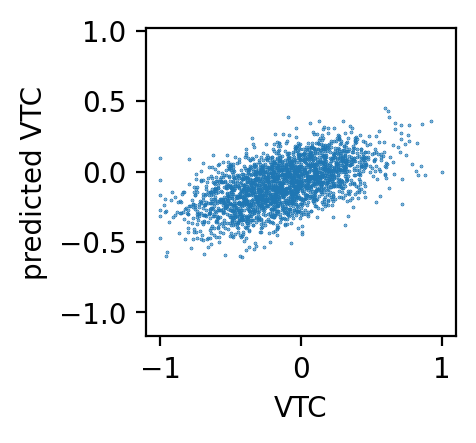

In [61]:
plt.figure(figsize=(2,2), dpi=200)
plt.scatter(VTC[0,:], predicted_VTC[0,:], s=0.1)
plt.xlabel('VTC')
plt.ylabel('predicted VTC')
plt.axis('equal')

##Plotting MNIST data

In [ ]:
# Assuming model, test_loader are defined as per previous instructions

def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Fetch a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Show original images
plt.figure(figsize=(10, 2))
plt.suptitle('Original Images')
imshow(torchvision.utils.make_grid(images[:5]))

# Reconstruct images through the network
model.eval()
with torch.no_grad():
    images_flat = images.view(images.size(0), -1)
    reconstructed, _ = model(images_flat)
    # Reshape the images to match the original dimensions
    reconstructed_images = reconstructed.view(images.size())

# Show reconstructed images
plt.figure(figsize=(10, 2))
plt.suptitle('Reconstructed Images')
imshow(torchvision.utils.make_grid(reconstructed_images[:5]))
plt.show()
